# MLP on Titanic dataset

In [2]:
import numpy as np
import pandas as pd 

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Pasul 1: se citeste setul de date

In [4]:
df = pd.read_csv("csv/titanic.csv")

In [113]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


## Pas2: Se genereaza statistici despre date

Aceste statistici se pot folosi pentru a vedea care feature-uri sunt relevante, pe ce coloane sunt missing values, distributia valorilor etc.

In [114]:
from pandas_profiling import ProfileReport

In [115]:
#Pentru seturi de date mari este indicat să folosim versiunea minimală a librăriei
prof=ProfileReport(df,minimal=True)

In [116]:
prof.to_file(output_file='html_stats/titanic-min.html')

## Pas3: selectarea feature-urilor

Unul dintre feature-urile relevante este sexul persoanei. In dataset acesta este exprimat printr-un String ("male" sau "female")

Pentru procesare stringul trebuie convertit in valoare numerica. Am ales sa reprezint "femal" ca si 1 si "male" ca si 0

In [5]:

from sklearn.preprocessing import LabelBinarizer
df = pd.read_csv("csv/titanic.csv")
df["Sex"] = np.where(df["Sex"] == "female", 1, 0)

Un alt element important sunt featur-urile irelevante sau cele care au multe valori Nan.
Feature-ul cabin are 77% missing values motiv pentru care nu este luat in considerare.
Feature-ul Name, Ticket, Embarked si PassengerId nu aduc plus de informatii.

In [6]:
X = df.drop(["Cabin", "Survived", "Name", "Title", "Embarked", "Ticket", "PassengerId"], axis=1)

Un feature relevant este cel de Title. 

Acesta are 6 vlaori distincte si este reprezentat printr-un string (Mr, Miss, Mr, Mrs, Master, Dr). 

Pentru transformare acestui feature in valori numerice foloses un labelBinarizer. Acesta va genera o martice de 6xlen(df) valori. Fiecare linie contine feature-ul transformat intr-o insirurire de 0 si 1. Exista doar un singur 1 pe linie si pozitia acestia corespunde cu Titlul pe care il inlocuieste.

La final concatenam matricea in care am encodat feature-ul de Title cu dataframe-ul

In [7]:
encoder = LabelBinarizer()
title = encoder.fit_transform(df["Title"])
X = pd.concat([X, pd.DataFrame(title)], axis=1)
print(X)

      Age     Fare  Parch  Pclass  Sex  SibSp  Family_Size  0  1  2  3  4  5
0    22.0   7.2500      0       3    0      1            1  0  0  0  1  0  0
1    38.0  71.2833      0       1    1      1            1  0  0  0  0  1  0
2    26.0   7.9250      0       3    1      0            0  0  0  1  0  0  0
3    35.0  53.1000      0       1    1      1            1  0  0  0  0  1  0
4    35.0   8.0500      0       3    0      0            0  0  0  0  1  0  0
..    ...      ...    ...     ...  ...    ...          ... .. .. .. .. .. ..
886  27.0  13.0000      0       2    0      0            0  0  0  0  0  0  1
887  19.0  30.0000      0       1    1      0            0  0  0  1  0  0  0
888  22.0  23.4500      2       3    1      1            3  0  0  1  0  0  0
889  26.0  30.0000      0       1    0      0            0  0  0  0  1  0  0
890  32.0   7.7500      0       3    0      0            0  0  0  0  1  0  0

[891 rows x 13 columns]


Survived reprezinta outputul de care avem nevoie, modiv pentru care il mutem in variabila y si il stergen dintre feature-uri.

In [8]:
y = df['Survived']

Pentru rezultate bune avem nevoie de normalizarea valorilor. 

EX: Daca avem feature-ul A cu valori intre 0 si 1 si feature-ul B cu valori intre 2000 si 3000, la training feature-ul B va influenta puternic rezultatul datorita valorilor sale foarte mari. Cu toate acestea se poate ca feature-ul A sa fie mult mai relevant, dar algoritmului ii va fi foarte greu sa tina cont datorita range-urilor diferite. Din acest motiv se foloseste un MinMaxScaler.

Functia dupa care se normalizeaza este

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

Si toate valorile vor fi in intervalul (-1 1)

In [9]:
# Functia va translata fiecare feature in parte in intervalul (-1,1)
# Funcția practic relizează următoarele
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler((-1, 1))
X = sc.fit_transform(X)

## Pas 4 Impartirea setului de date

Setul de date se imparte in 80% pentru train si 20% pentru validation.
De asemenea se face shuffle la date astfel incat daca in fisier aceste sunt cumva ordonate, pentru training sa fie in ordine aleatorie.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [11]:
X_test

array([[-0.33199296, -0.9459008 , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.03040965, -0.96906286, -1.        , ...,  1.        ,
        -1.        , -1.        ],
       [-0.65870822, -0.84507032, -0.66666667, ...,  1.        ,
        -1.        , -1.        ],
       ...,
       [-0.10580548, -0.6921901 , -1.        , ...,  1.        ,
        -1.        , -1.        ],
       [-0.20633325, -0.88093593, -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.84920834, -0.96964842, -1.        , ...,  1.        ,
        -1.        , -1.        ]])

In [12]:
import torch
from torch import nn, optim

In [13]:
X_train.shape

(712, 13)

In [14]:
y_train.shape

(712,)

In [15]:
X_test.shape

(179, 13)

Conversie valori in tensori

In [16]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train.values).long()
y_test = torch.tensor(y_test.values).long()

In [17]:
from torch.utils.data import Dataset, DataLoader
import torch
class Dataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, x, y):
        #Citim setul de date
        self.len = len(x)
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

Creare Loader pentru Validation si train. Cele 2 loadere impart datele in batch-uri de 32 si fac shuffle.

In [18]:
trainDataset=Dataset(X_train, y_train)
trainLoader=DataLoader(dataset=trainDataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=1)
validationDataset=Dataset(X_test, y_test)
validationLoader=DataLoader(dataset=validationDataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=1)

## 5. Reteaua neuronala

Se defineste structura retelei neuronale. Reteaua de fata are 4 layere: 1 de input, 2 hidden si 1 de output. De asemenea se definesc functiile de activare a neuronilor

In [80]:
class TitanicNN(nn.Module):
    def __init__(self):
        super(TitanicNN, self).__init__()

        #Sequential oferă o alternativă mai estetică a codului
        #Rețeaua noastră are 2 neuroni pentru output. 
        #Unul va prezice probabilitatea pentru cazul afirmativ iar celălalt va prezice probabilitatea cazului negativ.
        self.sequential= nn.Sequential(
            nn.Linear(13,30),
            nn.Sigmoid(),
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )


    def forward(self, x):
        return self.sequential(x)

In [85]:
net = TitanicNN()

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

softmax function or normalized exponential function is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities proportional to the exponentials of the input numbers. 

np.exp(a) / np.sum(np.exp(a))

a = [1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0] 

-> array([0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054,
       0.06426166, 0.1746813])
       
       
In practice, the softmax function is used in tandem with the negative log-likelihood (NLL). This loss function is very interesting if we interpret it in relation to the behavior of softmax. First, let’s write down our loss function:

L(y) = − log(y)

In [86]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [87]:
#Colectăm loss-urile din antrenare pentru a le plota ulterior
losses = []

In [88]:
# Colectăm accuratetea pentru a o plota ulterior
accuracies=[]
acc_validation = []
acc_train = []

In [89]:
from sklearn.metrics import accuracy_score

tainingul se face cu minibatch. pentru fiecare minibatch se fac predictii, se calculeaza loss-ul si apoi se face update la weight-uri.
De asemenea se salveaza si accuracy-ul pentru training.

In [90]:
def train(epoch):
    net.train()
    losses=[]
    correct = 0
    for batch_idx, data in enumerate(trainLoader, 0):
      inputs, labels =data
      outputs = net(inputs)
      # Compute and print loss
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pred = outputs.data.max(1, keepdim=True)[1]
      correct += pred.eq(labels.data.view_as(pred)).sum()
      #print(f"[Train Epoch: {epoch}, Batch: {batch_idx+1}, Loss: {loss.item()}")
    mean_loss=sum(losses)/len(losses)
    accuracy = 100. * correct/len(trainLoader.dataset)
    scheduler.step(mean_loss)
    train_losses.append(mean_loss)
    acc_train.append(accuracy)
    print(f"[TRAIN] Epoch: {epoch} Loss:{mean_loss}, Accuracy: {accuracy}%")    

In [91]:
# Colectăm loss-ul din validare pentru a o plota ulterior
test_losses=[]
train_losses = []

Dupa fiecare train se face masuratorile si pe setul de validation. Fara a modifica weight-urile, se evalueaza accuracy-ul si loss-ul pe setul de validare. Si pe setul de validare calculele se fac tot folosind mini-batch

In [92]:
def validation():
    #Pune pe off flagurile setate in model.train()
    net.eval()
    test_loss=[]
    correct = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(validationLoader, 0):
          inputs, labels = data

          output=net(inputs)
          loss= criterion(output, labels)
          test_loss.append(loss.item())

          pred = output.data.max(1, keepdim=True)[1]

          #Verificăm câte predicții sunt corecte și le însumăm numărul pentru a afla totalul de predicții corecte
          correct += pred.eq(labels.data.view_as(pred)).sum()
          current_correct=pred.eq(labels.data.view_as(pred)).sum()          
        mean_loss=sum(test_loss)/len(test_loss)
        test_losses.append(mean_loss)
        accuracy = 100. * correct/len(validationLoader.dataset)
        print(f"[Validation set] Loss: {mean_loss}, Accuracy: {accuracy}%")
        accuracies.append(accuracy)



In [93]:
#după fiecare epocă de train() verificăm rezultatele pe setul de validare
for epoch in range(500):
  train(epoch)
  validation()

[TRAIN] Epoch: 0 Loss:0.7043146853861602, Accuracy: 42.134830474853516%
[Validation set] Loss: 0.6908387839794159, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 1 Loss:0.6773598738338636, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.6817559997240702, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 2 Loss:0.6646205990210824, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.6754622856775919, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 3 Loss:0.6647694758746935, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.67206339041392, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 4 Loss:0.6605227719182554, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.6687128047148386, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 5 Loss:0.6583451680515123, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.6754536430040995, Accuracy: 59.21787643432617%
[TRAIN] Epoch: 6 Loss:0.6607990783193837, Accuracy: 62.21910095214844%
[Validation set] Loss: 0.6768260498841604, Accuracy: 59.21787643432617%


[Validation set] Loss: 0.47153379519780475, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 58 Loss:0.48406672866448114, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4773877263069153, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 59 Loss:0.4774007032746854, Accuracy: 78.65168762207031%
[Validation set] Loss: 0.4625966747601827, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 60 Loss:0.4800188204516535, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4729154109954834, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 61 Loss:0.4748817345370417, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4727350324392319, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 62 Loss:0.47556693528009497, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4534069001674652, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 63 Loss:0.46445018441780755, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4741856058438619, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 64 Loss:0.46344498966051184, Accuracy: 78.79213714

[Validation set] Loss: 0.4380175272623698, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 113 Loss:0.45050726118295087, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4416883885860443, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 114 Loss:0.4718762545481972, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44837385416030884, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 115 Loss:0.4461971171524214, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4405052661895752, Accuracy: 79.88826751708984%
Epoch   117: reducing learning rate of group 0 to 1.0000e-08.
[TRAIN] Epoch: 116 Loss:0.4583080151806707, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4460664838552475, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 117 Loss:0.447433326555335, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44657300412654877, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 118 Loss:0.44618387196374976, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4564974407354991, Accuracy: 79.88826751708984%

[TRAIN] Epoch: 169 Loss:0.4580188056697016, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4547663430372874, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 170 Loss:0.46377499595932337, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4404030342896779, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 171 Loss:0.45489376718583313, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43752218782901764, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 172 Loss:0.4447334680868232, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4461234410603841, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 173 Loss:0.44392725047857867, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4360332190990448, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 174 Loss:0.45008220491201983, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44154152274131775, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 175 Loss:0.44710654409035394, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44296639164288837, Accuracy: 79.

[TRAIN] Epoch: 226 Loss:0.44652991450351215, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44769838949044544, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 227 Loss:0.4556296117927717, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4425529142220815, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 228 Loss:0.44717756432035694, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44172706206639606, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 229 Loss:0.4452111163864965, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4429500997066498, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 230 Loss:0.4641534660173499, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4419921437899272, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 231 Loss:0.44722990497298865, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4488018850485484, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 232 Loss:0.44719274925149005, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44166308641433716, Accuracy: 79.8

[TRAIN] Epoch: 283 Loss:0.44394648463829706, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4387176185846329, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 284 Loss:0.45095314927723096, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4465423971414566, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 285 Loss:0.44578735336013464, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4345732827981313, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 286 Loss:0.4534039432587831, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.45060884455839795, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 287 Loss:0.4474842237389606, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4467163532972336, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 288 Loss:0.44504177829493646, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43392906586329144, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 289 Loss:0.4533661655757738, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4471917500098546, Accuracy: 79.88

[TRAIN] Epoch: 340 Loss:0.4456472617128621, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44280313948790234, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 341 Loss:0.44160926601161127, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.45821885764598846, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 342 Loss:0.4415616995614508, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44406702121098834, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 343 Loss:0.44965743111527484, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44258396327495575, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 344 Loss:0.44268093420111615, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4527693639198939, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 345 Loss:0.449499794970388, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43625134726365405, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 346 Loss:0.44617409809775976, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4447064052025477, Accuracy: 79.

[TRAIN] Epoch: 397 Loss:0.44445131913475366, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4473561644554138, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 398 Loss:0.45108396592347516, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4392619381348292, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 399 Loss:0.44326765900072845, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43961083392302197, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 400 Loss:0.4469813393509906, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4343900680541992, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 401 Loss:0.4501797038575877, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.45511270066102344, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 402 Loss:0.44717319763225055, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43335547546545666, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 403 Loss:0.4507357154203498, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4489514281352361, Accuracy: 79.8

[TRAIN] Epoch: 454 Loss:0.4467777104481407, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44973621765772503, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 455 Loss:0.44681822735330334, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4491588721672694, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 456 Loss:0.4462973397711049, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4432832847038905, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 457 Loss:0.45333517634350323, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.4367534468571345, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 458 Loss:0.4434597991082979, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44662924607594806, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 459 Loss:0.44450918358305225, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.43202877541383106, Accuracy: 79.88826751708984%
[TRAIN] Epoch: 460 Loss:0.45030524808427563, Accuracy: 78.7921371459961%
[Validation set] Loss: 0.44995400806268054, Accuracy: 79.

## 6. Validare

La final, dupa ce reteaua neuronala a fost antrenata, se face plot la loss-ul de pe datele de train si de validare. Acest grafic ajuta la depistarea problemelor cu privire la convergenta algoritmului, overfit si underfit

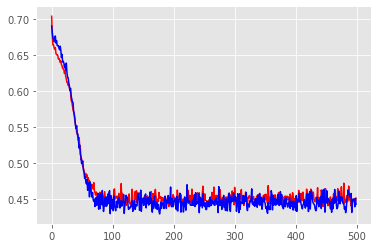

In [94]:
# Printăm comparativ cu roșu loss-ul de pe setul de validare și cu albastru loss-ul de pe setul de validare.
plt.plot(train_losses, "r-", test_losses, "b-")

Se mai poate face un grafic cu evolutia accuracy-ului pe cele 2 seturi de date.

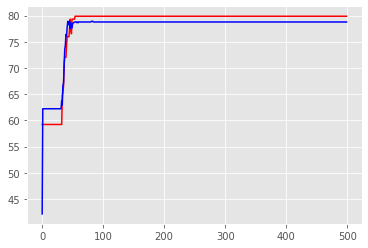

In [95]:
plt.plot(accuracies, "r-", acc_train, "b-")